<h1 align="center">Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information</h1>

<h5 align="center">Advanced Business Analytics (42578) - Exam Project</h5>


<h5 align="center">Group Name: Mind Machines</h5>
<h5 align="center">Students: Christoffer Wejendorp (s204090), Jasmin Thari (s204155), and Marah Marak (s182946)</h5>




### Structure of this notebook

This notebook is organized into seven distinct sections, each aimed at guiding you through various stages of the project from initial setup to in-depth analysis and discussions:

1. **[Introduction](#1)**: Provides an overview of the objectives and scope of the project.

2. **[Get Started](#2)**: Outlines the setup procedures including the installation of required packages within the notebook.

3. **[Data & Pre-processing](#3)**: Details the data set used in this project, followed by comprehensive steps involved in the data cleaning process to prepare the data for analysis.

4. **[Exploratory Data Analysis](#4)**: Dives into the data set through various visualization techniques to uncover patterns, trends, and insights which inform further analyses.

5. **[Named Entity Recognition using Regex](#5)**: Introduces a baseline model for Named Entity Recognition (NER) utilizing regular expressions (Regex). This section demonstrates how to apply Regex patterns and rules to identify named entities within the text.

6. **[Named Entity Recognition using Transformer Model](#6)**: Advances the NER approach by implementing the DistilBert Transformer model to achieve a more sophisticated and effective entity recognition.

7. **[Discussion](#7)**: Concludes with a critical analysis of the results obtained, discussing both the strengths and limitations of the methods used and suggesting potential areas for future work.

### Table of Contents
1. **[Introduction](#1)**
2. **[Get Started](#2)**
3. **[Data & Pre-processing](#3)**
4. **[Exploratory Data Analysis](#4)**
5. **[Named Entity Recognition using Regex](#5)**
6. **[Named Entity Recognition Using Transformer Model](#6)**
7. **[Discussion](#7)**

__________

<a id="1"></a>
## Section 1: Introduction

In today's digital age, safeguarding sensitive information is predominant. Our project, titled *Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information*, addresses this urgent need by developing AI-driven solutions tailored for both academic and corporate environments.

For companies, the implementation of AI to detect personal data from documents like cover letters and CVs is crucial. This practice helps mitigate potential biases—both explicit and implicit—during the hiring process, ensuring a fairer assessment of candidates. Meanwhile, in academic settings, universities often seek to share student essays and theses for educational enrichment. However, it is vital to prevent personal data leakage to protect student privacy. Our project facilitates this by enabling secure sharing that complies with privacy standards.

To handle this challenge, we will deploy Named Entity Recognition (NER) techniques to effectively identify PII from texts. Our approach begins with the application of regular expressions (Regex), a basic yet powerful tool for pattern recognition in texts. This will serve as our baseline model for detecting straightforward instances of PII. Subsequently, we will enhance the model by incorporating a more sophisticated method using the DistilBert Transformer model. This advanced model will enable us to identify complex PII, where context understanding is essential. 

Our project will be valuable for organizations and institutions seeking to enhance data privacy and security in their operations.

__________

<a id="2"></a>
## Section 2: Get Started

In [1]:
# Standard libraries
import json
import itertools
import re
import string
from collections import Counter
from itertools import chain
import math

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML

# NLP
import spacy
from spacy import displacy
from spacy.tokens import Doc, Span
from spacy.lang.en import English
spacy_nlp = spacy.load('en_core_web_sm')
eng_tokenizer = English().tokenizer

# Hugging Face
from datasets import load_dataset, load_from_disk
from transformers import (AutoTokenizer, 
                          AutoModelForTokenClassification, 
                          DataCollatorForTokenClassification, 
                          TrainingArguments, 
                          Trainer,
                          pipeline)
from omegaconf import OmegaConf                     
import evaluate
import torch

if torch.cuda.is_available(): # If there's a GPU available...
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

# Text Processing and Analysis
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Import custom functions
from Functions.Spacy_Tokenizer import *
from Functions.Ner_Visualizer import *
from Functions.tfidf_wordclouds import *

# Ignore warnings
pd.options.mode.chained_assignment = None

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No GPU available, using the CPU instead.


In [2]:
# Define the custom color theme
color_theme = {
    'three_colors': ['#57634B', '#D4793A', '#527184'],  
    'four_colors': ['#85977D', '#8498A5', '#587F86', '#BD8A3D'],  
    'five_colors': ['#57634B', '#D4793A', '#527184', '#CFA802', '#BBB599'], 
    'twelve_colors': ['#57634B', '#85977D', '#8498A5', '#527184', '#E9B649', '#BD8A3D', '#D4793A', 
                      '#7D1F1D', '#BB6D71', '#BBB599', '#BE477D', '#CDADE6']}

__________

<a id="1"></a>
# Section 3: Data

To address our business case effectively, we required two specific types of data: academic essays and professional summaries such as cover letters or CVs. We have sourced suitable datasets for both needs.

The first dataset, sourced from a Kaggle competition titled *The Learning Agency Lab - PII Data Detection*, comprises approximately 6,807 essays written by students from an online course. Each essay is a response to a task that involved applying course material to a real-world scenario. The goal is to identify and annotate any personally identifiable information (PII) within these essays. To ensure privacy, all actual PII has been substituted with surrogate identifiers through a semi-automated process. This dataset is accessible [here](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data).

The second dataset, created by a Large Language Model (LLM), is also hosted on Kaggle. It includes 4,434 annotated texts generated in response to eight different prompts, primarily focusing on life and job experiences. This dataset is available [here](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset).

### Project Goals
The aim of this project is to identify and annotate various types of PII, which include:

- **Name:** Identifying personal names, excluding names of instructors, authors, or other individuals.
- **Email:** Detecting personal email addresses.
- **Username:** Recognizing usernames.
- **ID Number:** Identifying ID numbers or social security numbers.
- **Phone Number:** Detecting personal phone numbers.
- **Personal URL:** Recognizing URLs that associated with individual.
- **Address:** Identifying street addresses related to individuals.

### Data Structure
The data provided includes detailed information about each document:

- **index (int):** An index number assigned to each document.
- **document id (int):** A unique integer identifier for each document.
- **full_text (string):** The complete text of each document in UTF-8 format.
- **tokens (list):** A sequence of tokens, derived using the SpaCy English tokenizer.
- **trailing_whitespace (list):** A list indicating whether a space follows each token.
- **labels (list):** These labels classify each token according to the type of PII they represent, using the BIO (Beginning, Inner, Outer) format:
  - **B-** prefix denotes the start of a PII entity.
  - **I-** indicates continuation of a PII entity.
  - **O** represents tokens unrelated to PII.

## 3.1 Data Loading

### 3.1.1 Loading the student essays dataset

In [3]:
# Load data in dataframe format
essays_df = pd.read_json('data/train.json')
print('Number of documents:',len(essays_df))

Number of documents: 6807


In [4]:
essays_df.head(2)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


### 3.1.2 Loading LLM generated data about life and job summaries

In [5]:
# Load LLM generated data in dataframe format
summaries_df = pd.read_csv('data/pii_dataset.csv')
print('Number of documents:',len(summaries_df))

Number of documents: 4434


In [6]:
summaries_df.head(2)

,document,text,tokens,trailing_whitespace,labels,prompt,prompt_id,name,email,phone,job,address,username,url,hobby,len
0,1073d46f-2241-459b-ab01-851be8d26436,"My name is Aaliyah Popova, and I am a jeweler ...","['My', 'name', 'is', 'Aaliyah', 'Popova,', 'an...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Aaliyah Popova is a jeweler with 13 year...,1,Aaliyah Popova,aaliyah.popova4783@aol.edu,(95) 94215-7906,jeweler,97 Lincoln Street,NaN,NaN,Podcasting,363
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"My name is Konstantin Becker, and I'm a develo...","['My', 'name', 'is', 'Konstantin', 'Becker,', ...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Konstantin Becker is a developer with 2 ...,1,Konstantin Becker,konstantin.becker@gmail.com,0475 4429797,developer,826 Webster Street,NaN,NaN,Quilting,255


Let's explore the number of different prompt IDs present in the data.

In [7]:
len(summaries_df['prompt_id'].unique())

8

Below, we display a random sample for each prompt ID, where the prompt ID represents a category, each prompt within the same category is unique.

In [ ]:
# Group by 'prompt_id', sample one record from each group.
sampled_prompts = summaries_df.groupby('prompt_id').apply(lambda x: x.sample(1), include_groups=False).reset_index(drop=False)
html = '<table>'
html += '<tr><th>Prompt ID</th><th>Text</th></tr>'  
for index, row in sampled_prompts.iterrows():
    html += f'<tr><td>{row["prompt_id"]}</td><td>{row["prompt"]}</td></tr>'

html += '</table>'
display(HTML(html))

Prompt ID,Text
0,"Write a fictional semi-formal biography in first person for Krishna Kimura. Add the following information about him/her randomly inside the text: name is Krishna Kimura, phone number is 0837 1341304, email is krishna.kimura2152@aol.net, address is 14 Huntington Street."
1,"Yasuko Gross is a carpenter with 4 years of experience. Write a detailed example in first person of a job-related project he/her did in the past. Add the following information about him/her randomly inside the text: name is Yasuko Gross, phone number is 0877 766 9078, email is yasuko-gross8489@outlook.gov, hobby is Escape rooms, address is 5611 Kendall Court."
2,"Tadashi Anderson is a coach. Write about a job-related project he/her did in the past including some of the following information: phone number is +91-86774 19311, email is tadashi_anderson1409@msn.org"
3,"Ahmed Rousseau is a carpenter. Write a first person summary of something he solved in his job. Add the following information about him/her randomly inside the text: name is Ahmed Rousseau, email is ahmed.rousseau@hotmail.net, address is 3231 North Kings Cross."
4,"Write a fictional semi-formal biography in first person for Louis Pereira. Add the following information about him/her randomly inside the text: name is Louis Pereira, profile at Instagram is l.pereira, email is louis.pereira@gmail.gov, webpage is www.louis-pereira.com/about.css. It is important to include this information in different parts of the text."
5,"Manchu Lin is a professor with 11 years of experience. Write a detailed example in first person of a job-related project he/her did in the past. Add the following information about him/her randomly inside the text: name is Manchu Lin, webpage is mlin.net, profile at Facebook is manchu.lin90, address is 9695 Chelsea Street Apt. 305."
6,"Jesus Ivanova is a petroleum engineer. Write about a job-related project he/her did in the past including some of the following information: phone number is +86 19947 9098, profile at Indeed is jesusivanova. It is important to include this information randomly throughout the text."
7,"Bowen Lambert is a teacher. Write a first person summary of something he solved in his job. Add the following information about him/her (randomly please) inside the text: name is Bowen Lambert, email is bowenlambert@aol.edu, address is 445 Amber Parks Apt. 038, profile at Twitter is @blambert, webpage is blambert.edu/newsletter.php."


From the output, we can observe that the majority of the prompts are related to summaries of job-related or life experience topics. 

## 3.2 Pre-processing

First, we will preprocess both datasets to ensure they are aligned. For example, we will rename the text columns in both datasets to "text", add a new column to track which data is generated by LLMs, and assign a prompt ID of -1 to the non-generated data to facilitate tracking.

In [8]:
essays_df = essays_df.rename(columns={'full_text':'text'}) # Rename column to 'text'
essays_df['labels'] = essays_df['labels'].apply(lambda x: [re.sub('B-NAME_STUDENT', 'B-NAME', tag) for tag in x]) # Rename one ner tag
essays_df['labels'] = essays_df['labels'].apply(lambda x: [re.sub('I-NAME_STUDENT', 'I-NAME', tag) for tag in x]) # Rename one ner tag
essays_df['llm_generated'] = False # Add column to indicate if the text was generated by LLM
essays_df['prompt_id'] = -1  # Add column to indicate the prompt id

In [9]:
summaries_df['llm_generated'] = True # Add column to indicate if the text was generated by LLM
summaries_df[["tokens", "trailing_whitespace", "labels"]] = summaries_df[["tokens", "trailing_whitespace", "labels"]].map(ast.literal_eval) # Convert string to list
summaries_df['labels'] = summaries_df['labels'].apply(lambda x: [re.sub('B-NAME_STUDENT', 'B-NAME', tag) for tag in x]) # Rename one ner tag
summaries_df['labels'] = summaries_df['labels'].apply(lambda x: [re.sub('I-NAME_STUDENT', 'I-NAME', tag) for tag in x]) # Rename one ner tag
summaries_df["document"] = summaries_df["document"].astype("category").cat.codes + (essays_df.document.max() + 1) # make sure document id is unique and changing to int

**Addressing the Punctuation Issue in the LLM generated data set**:

In the context of text processing, particularly when handling datasets for named entity recognition (NER), punctuation plays a crucial role in determining the boundaries and labels of tokens. The standard tokenization by tools like SpaCy segment a phrase such as "Charles, by" into ["Charles", ",", "by"] with trailing spaces marked as [False, True, True], and labels ["B-NAME", "O", "O"]. This segmentation accurately reflects the presence of punctuation as separate from named entities, even when there's no space between them.

However, the LLM generated dataset presents a unique challenge, where all token are seperated by space so its tokenization will be ["Charles,", "by"] [True, True] ["B-NAME", "O"] and thus tokens without space are considered single token and are given single labels. While the tokenization will leas to the same text e.g ["Char", "les", ",", "_by"], the model labels will be different ["B-NAME", "B-NAME", "B-NAME", "O"] instead of appropriate ["B-NAME", "B-NAME", "O", "O"]. 

So, this approach results in punctuation being considered part of a preceding token, thus receiving a single, unified label. Consequently, when aligning the LLM dataset's tokenization with the original, we encounter difference.

To resolve this, adjustments are necessary to ensure that the dataset aligns more closely with standard tokenization and labeling practices. This involves re-evaluating tokens and labels to correctly identify and separate punctuation from named entities, thereby avoiding the mislabeling that can confuse NER models. By addressing this issue, we aim to improve the dataset's utility for training more accurate and reliable NER systems.

> NB! The following code uses functions from `Spacy_Tokenizer.py` file. 

In [10]:
summaries_df_tokenized = summaries_df.apply(adjust_token_labels, axis=1)
summaries_df_tokenized["labels"] = summaries_df_tokenized.apply(refine_punctuation_labels, axis=1).apply(create_bio_labels)
summaries_df_tokenized['text'] = summaries_df['tokens'].apply(lambda x: ' '.join(x))
summaries_df_tokenized[['prompt_id', 'llm_generated']] = summaries_df[['prompt_id', 'llm_generated']]

In [11]:
summaries_df_tokenized.head(2)

,document,tokens,trailing_whitespace,labels,text,prompt_id,llm_generated
0,22968,"[My, name, is, Aaliyah, Popova, ,, and, I, am,...","[True, True, True, True, False, True, True, Tr...","[O, O, O, B-NAME, I-NAME, O, O, O, O, O, O, O,...","My name is Aaliyah Popova, and I am a jeweler ...",1,True
1,24398,"[My, name, is, Konstantin, Becker, ,, and, I, ...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME, I-NAME, O, O, O, O, O, O, O,...","My name is Konstantin Becker, and I'm a develo...",1,True


In [12]:
print("Thus, the first row's tokens are transformed from " + str(len(summaries_df_tokenized['tokens'].iloc[0])) + " to " + str(len(summaries_df['tokens'].iloc[0])) + " tokens and are more aligned with the first data set and the more approciate tokenizer.")

Thus, the first row's tokens are transformed from 411 to 363 tokens and are more aligned with the first data set and the more approciate tokenizer.


### 3.2.1 Combine data sets

Both that data sets have now been pre-processed and we are ready to combine them into one data set.

In [13]:
df = pd.concat([essays_df, summaries_df_tokenized], ignore_index=True)

In [14]:
print('Number of documents:',len(df))

Number of documents: 11241


In [15]:
df.head(2)

,document,text,tokens,trailing_whitespace,labels,llm_generated,prompt_id
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME, I-NAME, O,...",False,-1
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME, I-NAME, O, O, O, O, O, O, O, O, O, O,...",False,-1


__________

<a id="4"></a>
# Section 4: Exploratory Data Analysis

## 4.1 Data Visualization

### 4.1.1 Target Distrbution

First, we are examining the frequency of each target in all the documents excluding target "O" to investigate the distribution of PII entities in the data.

In [ ]:
labels = df['labels'].tolist()
# Flatten the list of lists
flattened_labels = list(itertools.chain.from_iterable(labels))
# Count the occurrences of each label
label_counts = Counter(flattened_labels)
# Separate the labels and their counts for plotting
labels, counts = zip(*label_counts.items())

# add the number on top of each bar 
labels = list(labels)
counts = list(counts)
for i in range(len(labels)):
    labels[i] = labels[i] + ' (' + str(counts[i]) + ')'
    
# Create the bar plot 
fig = go.Figure([go.Bar(x=labels[1:], y=counts[1:], marker_color=color_theme['three_colors'][2])])
fig.update_layout(title_text='Frequency of each label', xaxis_title='Labels', yaxis_title='Frequency')
fig.show()

- It is evident that the most common targets within our data are *B-NAME*, *I-NAME*, *B-STREET_ADDRESS*, and *I-STREET_ADDRESS*. Notably, *NAME* appears most frequently.
- We also find that certain targets are notably rare, such as *B-ID_NUM*, *I-URL_PERSONAL*, and *I-ID_NUM*.
- Additionally, we observe the absence of potential targets like *I-EMAIL* and *I-USERNAME*. However, the scarcity of these targets is expected since emails and usernames typically do not extend beyond a single word.
- Overall, we have a diverse array of targets, which is crucial for effective model training.

In the following analysis, we will examine the number of unique targets in each document. This will provide us with information about the number of different PII entities present in each document.

In [ ]:
df['unique_labels'] = df['labels'].apply(lambda x: list(set(x)))
df['num_unique_labels'] = df['unique_labels'].apply(len)

# Histogram of number of unique labels per document
fig = px.histogram(df, x='num_unique_labels', nbins=20,
                   labels={'num_unique_labels': 'Number of unique labels'},
                   title='Histogram of number of unique labels per document',
                   color_discrete_sequence=[color_theme['three_colors'][2]])
fig.update_layout(yaxis_title='Frequency') 
fig.show()


- It is shown that we have around 5871 documents with one unique target which is "O", since the data does not contain texts, that solely consists of PII targets. Thus, we have 5871 documents with no PII entities. 
- Additionally, it is noteworthy that some texts contain 6 to 8 unique labels.

It is interesting to examine the number of targets in each document when excluding the "O" label.

In [ ]:
df['num_labels'] = df['labels'].apply(lambda labels: len([label for label in labels if label != "O"]))
filtered_df = df[df['num_labels'] > 0]
# Histogram of number of unique labels per document
fig = px.histogram(filtered_df, x='num_labels', nbins=50, 
                   labels={'num_labels': 'Number of labels'},
                   title='Histogram of number of labels per document', color_discrete_sequence=[color_theme['three_colors'][2]])
fig.update_layout(yaxis_title='Frequency') 
fig.show()

> A small number of documents feature a high count of targets.
> For the majority, however, documents typically have between 5 to 15 targets.

### 4.1.2 Document distribution

It is interesting to investigate the distribution of documents in terms of text length and token count. 

First, we will visualize the lengths of text for documents, comparing those with labels to those without.

In [ ]:
df_with_labels = df[df['labels'].apply(lambda x: len(set(x)) > 1)] #with labels
df_non_labels = df[df['labels'].apply(lambda x: 'O' in x and len(set(x)) == 1)] #without labels 

df_with_labels['Documents'] = 'With PII targets'
df_non_labels['Documents'] = 'Without PII targets'

# Combine the dataframes
combined_df = pd.concat([df_with_labels, df_non_labels])

combined_df['Numbers of tokens'] = combined_df['tokens'].apply(len)
# Plotting
fig = px.histogram(combined_df, x='Numbers of tokens', color='Documents', color_discrete_sequence=color_theme['three_colors'][1:3],
                   nbins=500, title='Histogram of number of tokens per document')
fig.show()


- The distribution of number of tokens for both documents with and without labels approximates a heavy-tailed normal distribution.
- Noteably, the majority of documents containing PII targets have less than approximately 500 tokens. 

## 4.2 NER using spaCy 

Next, we will use the spaCy library to visualize text data along with their corresponding labels for NER.

> !NB We are using function from `Ner_Visualizer.py` file. 

First, we are presenting a text that contains the highest number of unique labels, which, in our dataset, reached a maximum of eight.

In [36]:
visualize_ner(df.sort_values(by=["num_unique_labels"], ascending=False).reset_index(drop=True).iloc[0:1])

- The illustration demonstrates the accurate labeling of the text. Additionally, it highlights the use of labels that indicate both the beginning of the target entity and its continuation. 
- Finally, we observe that this is a text about a person's job experiences, which is a common theme in our data set.

## 4.3 WordClouds using TF-IDF

In the following analysis, we will create a word cloud using TF-IDF to highlight the most predominant words in the document. 

Term Frequency-Inverse Document Frequency (TF-IDF), is a NLP technique used to evaluate the importance of a word to a document in a collection or corpus. It increases proportionally with the number of times a word appears in the document but is offset by the frequency of the word across the corpus. This helps to adjust for the fact that some words appear more frequently in general and provides a way to prioritize words that are uniquely significant to a particular document.

**Term Frequency (TF)** measures how frequently a term appears in a document. It's calculated by dividing the number of times a specific word appears in a document by the total number of words in that document. This normalization helps to adjust for the varying lengths of documents.

**Inverse Document Frequency (IDF)** assesses the general importance of a term across a set of documents or a corpus. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. This helps to diminish the weight of terms that occur very frequently across the corpus and increases the weight of terms that occur rarely. IDF essentially answers the question, "How important is this word in the entire corpus?"

TF-IDF is obtained by multiplying the two metrics for each term in a document: TF (how common the term is within the single document) times IDF (how unique or rare the term is across all documents). This calculation results in a weight for each word. Words that are common in a document but rare in other documents receive a high TF-IDF score. Conversely, words that are common both in a specific document and across many or all other documents receive a low TF-IDF score. This means TF-IDF tends to filter out common words such as "the", "is", and "and", which appear in many documents and are less informative in the analysis.

> !NB functions can be found in the file `tfidf_wordclouds.py`.

First, we are doing wordclouds of all documents, to investigate if there is any interesting pattern in the documents.

Initially, we use the function `preprocess_texts` to preprocess the text. This includes: 
1. Convert each text to lowercase.
2. Remove non-alphabetic characters and split the text into words.
3. Remove stopwords using the English language stopwords set.
4. Lemmatize the remaining words using WordNet lemmatizer.

In [38]:
documents = preprocess_texts(df)

In [39]:
tokenize_documents = [doc.lower().split() for doc in documents]
tfidf_documents = calc_td_idf(tokenize_documents)
combined_tfidf = aggregate_tfidf_scores(tfidf_documents)

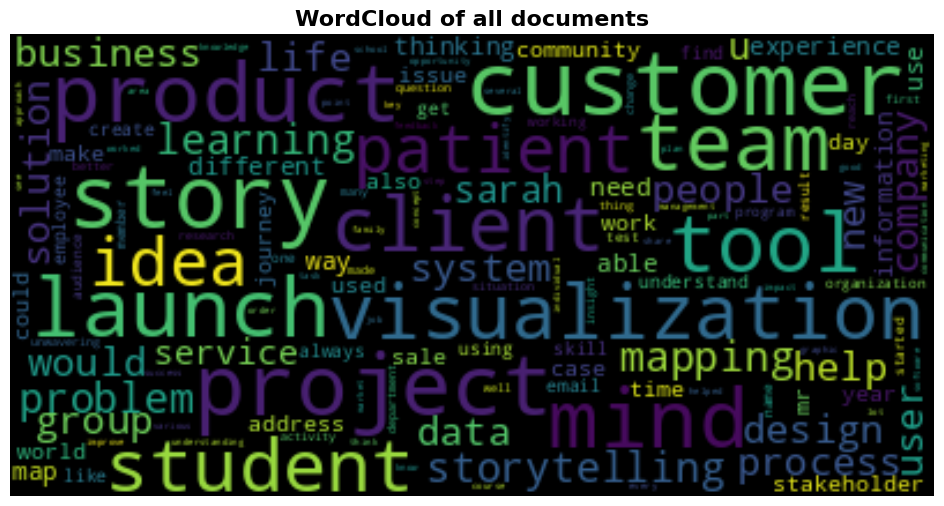

In [40]:
plot_wordcloud("WordCloud of all documents", combined_tfidf)

- We observe that the most important terms include words such as 'idea', 'customer', 'product', 'project', 'launch' 'team', and 'client,' among many others in the same category. These remind us that we are working with data containing many documents that include summaries of one's job and career. Consequently, the presence of these terms is not surprising.

Next, we will visualize most frequent names in the data.

In [41]:
extracted_tokens_per_document = []

for _, row in df.iterrows():
    document_tokens = [token for token, label in zip(row['tokens'], row['labels']) if label in ['B-NAME', 'I-NAME']]
    extracted_tokens_per_document.append(document_tokens)

In [42]:
tokenize_names = [[word.lower() for word in sublist] for sublist in extracted_tokens_per_document]
tfidf_names = calc_td_idf(tokenize_names)
combined_tfidf_names = aggregate_tfidf_scores(tfidf_names)

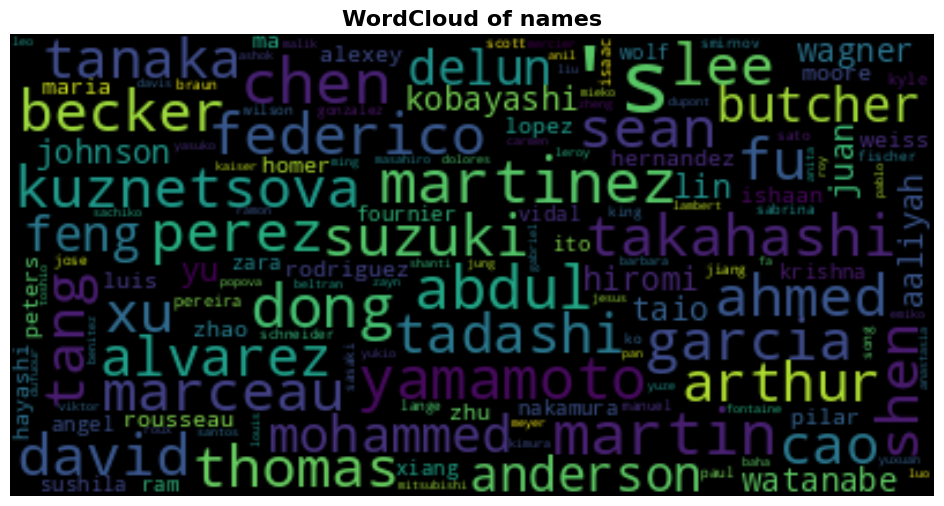

In [43]:
plot_wordcloud("WordCloud of names", combined_tfidf_names)

- What we notice here is the variety of names. We see typically European/American names like "Federico," "Alexey," "Martin," "Maria," and other Estern names such as "Ahmed," "Shen," "Malik," "Isaac," and more. This is very good, as we will have diverse data set, which will be good for the model generalization. 
- We also notice that '"S" and "'" is one of the names; this is due to the fact that this must be part of a name which the tokenizer has splitted into multiple tokens.
- We also see that all names are almost equally large, which is good as we have a balanced data set in terms of names, which means that we don't have names that are very frequent and others that are very rare.

When carrying out Named Entity Recognition tasks, one critical consideration is whether to convert all text to lowercase. This is because capitalization can often indicate proper nouns, such as names or addresses, which are useful for the model to identify. We conducted a word cloud analysis without converting the text to lowercase to explore this aspect further. However, the analysis did not reveal any notable patterns, so we have chosen not to include those results here. Nevertheless, we plan to investigate further how capitalization might impact our modeling efforts in future analyses.

In the following, we will investigate whether there are specific words before the respective labels. We will only do the TF part of TF-IDF. This can serve as an understanding of where the labels occur in the data and whether there is some very specific words, which could be used to the baseline model for rules. 

In [44]:
def extract_tokens_before_labels(data_df, target_label, num_tokens=1):
    all_tokens_before_label = []
    
    for _, row in data_df.iterrows():
        tokens, labels = row['tokens'], row['labels']
        # lower case tokens 
        tokens = [token.lower() for token in tokens]
        tokens_before_label = [
            tokens[i-num_tokens:i] 
            for i, label in enumerate(labels) 
            if label == target_label and i-num_tokens >= 0
        ]
        all_tokens_before_label.extend(tokens_before_label)
    
    return all_tokens_before_label

def clean_tokens(tokens):
    cleaned_tokens_per_document = [
    [re.sub(r'[^\w\s]', '', token) for token in sublist]
    for sublist in tokens]

    cleaned_tokens_per_document = [
        [token for token in sublist if token.strip()]
        for sublist in cleaned_tokens_per_document]

    all_tokens = [token for sublist in cleaned_tokens_per_document for token in sublist]
    return all_tokens

def plot_most_common_words(tokens, title, num_most_common_words=10):
    all_tokens = clean_tokens(tokens)
    # Count the frequencies of each word
    word_counts = Counter(all_tokens)
    # Get the most common words and their counts
    most_common_words = word_counts.most_common(num_most_common_words)
    words, frequencies = zip(*most_common_words)
    # Create a bar plot
    fig = go.Figure([go.Bar(x=words, y=frequencies, marker_color=color_theme['three_colors'][2])])
    fig.update_layout(title=title, xaxis_title='Words', yaxis_title='Frequency')
    fig.show()

In [45]:
# Extracting the two tokens before:
tokens_before_B_NAME_STUDENT = extract_tokens_before_labels(df, 'B-NAME')
tokens_before_B_STREET_ADDRESST = extract_tokens_before_labels(df, 'B-STREET_ADDRESS')
tokens_before_B_PHONE_NUM = extract_tokens_before_labels(df, 'B-PHONE_NUM')
tokens_before_B_URL_PERSONAL = extract_tokens_before_labels(df, 'B-URL_PERSONAL')
tokens_before_B_EMAIL= extract_tokens_before_labels(df, 'B-EMAIL')

In [ ]:
plot_most_common_words(tokens_before_B_NAME_STUDENT, "Most common words before B-NAME", 20)

- This figure displays the most common words preceding the target `B-NAME`. Most of these words are unremarkable pronouns such as "is", "of", and "am". 
- However, some notable exceptions are "Dr", "officer" and "professor", which suggests that some individuals use a title before their names. This could serve as an indication of a name, adding an interesting dimension to the analysis.

In [ ]:
plot_most_common_words(tokens_before_B_STREET_ADDRESST, "Most common words before B-STREET_ADDRESS", 20)

- Here, we observe the most common words preceding the target `B-STREET-ADDRESS`. It is unsurprising that "at" frequently appears in this context. However, we anticipated a higher occurrence of words like "address" and "street." 
- Nevertheless, this insight can be leveraged to enhance our baseline model by combining other indicative factors of an address with the word "at." For example, if certain criteria are met alongside the appearance of "at," we could classify the phrase as an address.

In [ ]:
plot_most_common_words(tokens_before_B_PHONE_NUM, "Most common words before B-PHONE_NUM", 20)

- For the target `B-PHONE-NUM`, we once again find that words such as "at", "is", and "or" are most common. Interestingly, "number" also appears frequently following these conjunctions and prepositions. This pattern underscores potential cues for identifying phone numbers in text data.
- Additionally, we observe words such as "call", "calling", "digits", and "phone", which are contextually related to phone numbers. However, their occurrence is not frequent enough to reliably use them as part of the regex model for identifying phone numbers.

In [ ]:
plot_most_common_words(tokens_before_B_URL_PERSONAL, "Most common words before B-URL_PERSONAL", 20)

- For the target `B-URL_PERSONAL`, we see the same tendency. Interestingly, "webpage" and "website" also appears, but not so commonly.  

In [ ]:
plot_most_common_words(tokens_before_B_EMAIL, "Most common words before B-EMAIL", 20)

- For the target `B_EMAIL`, we see no interesting words.

Overall, this analysis reveals that the most common words preceding the targets are pronouns, which is not so surprising. However, we had expected to see terms like "email," "street address," and "website" occurring more frequently before their respective targets. Such occurrences could have been highly beneficial for developing our baseline model.

This analysis provides valuable insights into the context surrounding PII entities in our data. By examining the most common words preceding each target, we wanted to identify potential patterns and cues that may aid in the accurate identification of PII. This information could be interesting in developing our baseline model using regular expressions. However, we did not see any particularly strong patterns that could be leveraged for this purpose.

___________

<a id="5"></a>
# Section 5: Named Entity Recognition using Regex

Named Entity Recognition (NER) is a process in which text is analyzed to locate and classify named entities into predefined categories such as names, email addresses, and ID numbers. In our project, we will employ regular expressions (regex) as a baseline method for NER, specifically to identify personally identifiable information (PII) in documents. This rule-based approach leverages manually crafted rules to detect and categorize named entities. By setting up regex as our initial method, we establish a benchmark for evaluating more advanced machine learning models later in the project.

Our first step involves defining the necessary regex rules to guide the identification process and ensure precise extraction of sensitive data. While regex offers speed and precision, its performance may be limited in handling diverse and large datasets, highlighting the need for more adaptable techniques in future phases of our work.

Initially, we will outline the rules governing the regex model. These rules are designed to efficiently capture most types of data relevant to our needs. Each category has a detailed rule to ensure precise and targeted data extraction:

1. **NAME**: The first regex pattern is designed to match names. It is designed to match any sequence of words where each word starts with an uppercase letter followed by one or more lowercase letters. This pattern is designed to capture names in the format of "Firstname Lastname" or "Firstname Middlename Lastname", but not the first word: "Here, is some text", as it is not followed by word starting with uppercase letter. Thus, we ensure that the first word in each sentence is not captured.

2. **EMAIL**: Simplifies capturing email addresses by identifying strings that include an `@` sign surrounded by non-space characters, indicative of a standard email format.

3. **ID_NUM**: This pattern is to match any sequence of 10 to 14 digits, typically used for identification numbers such as social security or employee ID.

4. **PHONE_NUM**: Captures phone numbers in two formats: one with parentheses around the area code followed by a digits as `(00)12345-1234`, and another in a dot-separated format as `123.456.789`. 

5. **STREET_ADDRESS**: Looks for an address starting with 2 to 4 numbers followed by a capitalized word. 

6. **USERNAME**: Matches any character string that starts with a `@` sign followed by alphanumeric characters (letters and numbers).

7. **URL_PERSONAL**: identifies simplified URLs, which could match both `HTTP` and `HTTPS` URLs and those that may or may not start with `www.`


In [50]:
# define regex patterns based on the rules
patterns = {
    'NAME': re.compile(r'\b([A-Z][a-z]+)(\s+[A-Z][a-z]+)+\b'),
    'EMAIL': re.compile(r'\b[\w.-]+@[\w.-]+\b'),
    'ID_NUM': re.compile(r'(?<!\d)(?<!\d\s)\b\d{10,14}\b(?!\s\d)(?!\d)'), 
    'PHONE_NUM': re.compile(r'\(\s*\d{2,3}\s*\)\s*[\d.-]+|'r'\d{2,3}\.[\d.-]+' ),
    'STREET_ADDRESS': re.compile(r'\b(\d{2,4})\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b'),
    'URL_PERSONAL': re.compile(r'\b(?:http://www\.|https://www\.|http://|https://)[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}\b'),
    'USERNAME': re.compile(r'\s@[a-zA-Z\d]+')
}

In the following, we implement our regex (baseline) model. 

First the function `match_regex_patterns` is utilized to identify the defined patterns in the text. Afterwards, the function `convert_to_bio_format` converts the labels into the BIO format. If two identical pattern matches are next to each other, the second label is marked as "I-" (inner) and the first label is marked as "B-" (beginning).

In [51]:
def match_regex_patterns(tokens: list, patterns: dict):
    # Join all tokens into a single string with spaces
    text = ' '.join(tokens)
    
    # Initialize the matches list with 'O'
    matches = ['O'] * len(tokens)
    
    # Mapping from index in tokens to index in text
    token_indices = []
    current_position = 0
    for token in tokens:
        token_indices.append((current_position, current_position + len(token)))
        current_position += len(token) + 1
    
    # Apply each regex to the full text
    for key, pattern in patterns.items():
        for match in pattern.finditer(text):
            match_start = match.start()
            match_end = match.end() - 1
            
            # Correcting the start index if it includes a leading space
            if text[match_start] == ' ':
                match_start += 1  # Move start index right to skip the space

            # Find tokens covered by this match
            start_token = next((i for i, (start, end) in enumerate(token_indices) if start <= match_start <= end), None)
            end_token = next((i for i, (start, end) in enumerate(token_indices) if start <= match_end <= end), None)

            if start_token is not None and end_token is not None:
                # Assign the match key to the corresponding tokens
                for i in range(start_token, end_token + 1):
                    matches[i] = key
    return matches

def convert_to_bio_format(labels: list):
    bio_labels = ['O'] * len(labels)
    for i, label in enumerate(labels):
        if label != 'O':
            if i == 0: 
                bio_labels[i] = 'B-' + label
            if (i > 0) & (labels[i] == labels[i-1]): # Check if the previous token has the same label
                bio_labels[i] = 'I-' + label
            else:
                bio_labels[i] = 'B-' + label
    return bio_labels

In [52]:
df['matched_regex_labels'] = df['tokens'].apply(lambda tokens: match_regex_patterns(tokens, patterns))
df['matched_regex_bio_labels'] = df['matched_regex_labels'].apply(lambda labels: convert_to_bio_format(labels))

In [54]:
true_labels_list = df['labels'].explode().tolist()
regex_predicted_labels_list = df['matched_regex_bio_labels'].explode().tolist()

# Ensure both lists have the same length before continuing
assert len(true_labels_list) == len(regex_predicted_labels_list), "The lists of true and predicted labels must be the same length."

# Get unique labels/classes 
unique_labels = ['O', 'B-NAME', 'I-NAME', 'B-EMAIL', 'I-EMAIL','B-PHONE_NUM', 'I-PHONE_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'B-URL_PERSONAL', 'I-URL_PERSONAL', 'B-USERNAME', 'I-USERNAME', 'B-ID_NUM', 'I-ID_NUM']

To assess the performance of our model, we will begin by visualizing the results through a confusion matrix. This matrix will clearly illustrate the accuracy of our model's predictions across different categories, highlighting how effectively it distinguished between them in the dataset.


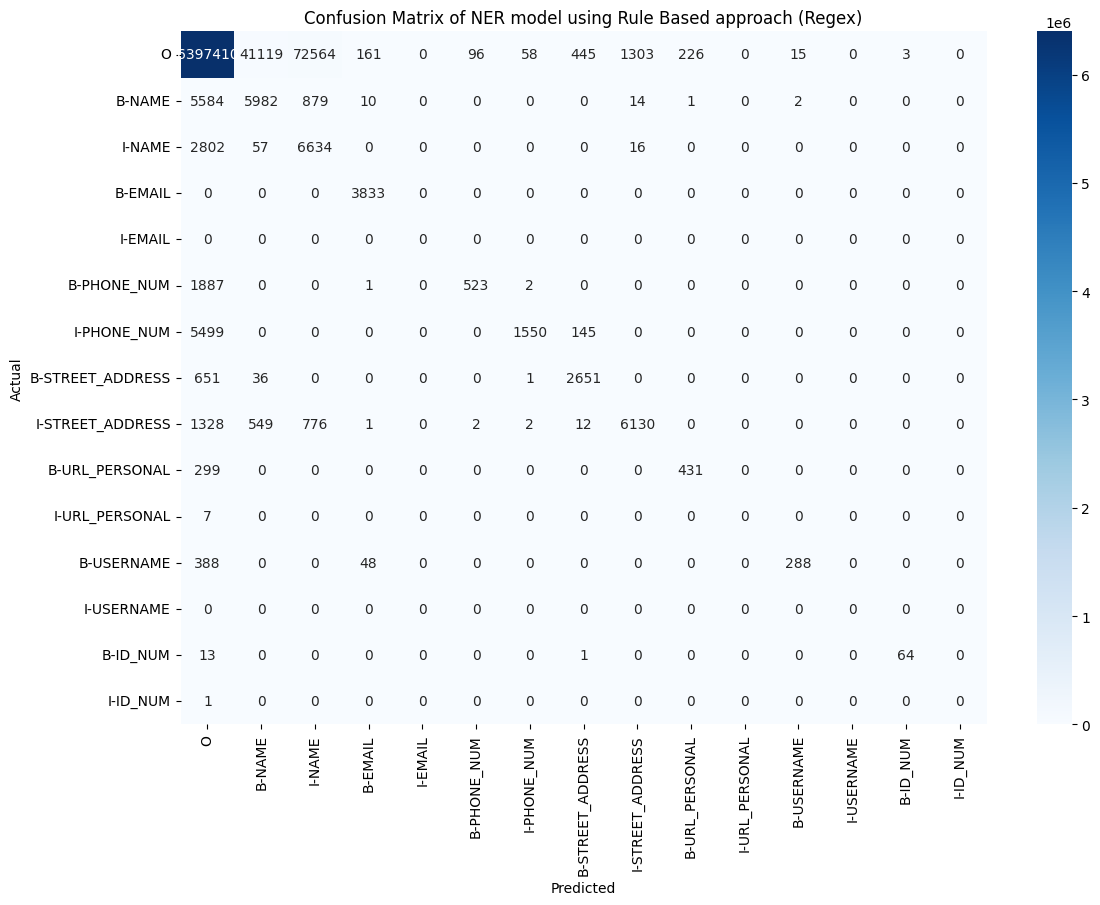

In [55]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels_list, regex_predicted_labels_list, labels=unique_labels)

fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues', cbar=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of NER model using Rule Based approach (Regex)')
plt.show()

- First, we observe that the baseline model significantly misclassifies B-NAME and I-NAME tags as "O". This isn't particularly surprising, considering that the model tends to classify any pair of capitalized words as a name. 
- Additionally, the model performs well in detecting B-EMAIL, with only a few instances being misclassified. This effectiveness is expected, as most email addresses contain the '@' symbol. 
- However, the model shows limited capability in detecting phone numbers. 
- Generally, we see that the model has problems seperating between PII and non-PII, but not seperating the different types of PII. 

In the following, we will compute the overall evaluation metrics for our regex model. We will calculate the accuracy, precision, recall, and F1 score for each category, providing a comprehensive overview of the model's performance. 
 
However, accuracy is not the most meaningful metric in this context because the overwhelming majority of tokens correctly labeled as 'O' (non-entities) can skew the results, giving a false impression of high model performance while potentially overlooking the minority classes of actual named entities that are crucial for our NER task, why the other metrics are more important.

The F1 score is a crucial metric for evaluating our model because it provides a balance between precision and recall. This is especially important when dealing with imbalanced classes, as is often the case in NER tasks. The F1 score conveys the harmonic mean of precision and recall, giving us insight into the overall effectiveness of the model in correctly classifying entities while considering both false positives and false negatives.

In scenarios where missing a true entity (a false negative) is more costly or critical than incorrectly labeling a non-entity (a false positive), recall becomes a more significant metric than precision. Recall measures the model's ability to detect all relevant instances, ensuring that the system captures as much of the sensitive information as possible. For our NER task, this is vital to ensure that sensitive data is not overlooked, which could lead to privacy breaches or data leakage. Hence, a high recall is indicative of the model’s thoroughness, while the F1 score gives us a sense of the model's balanced performance in situations where both false negatives and false positives are concerns.

In [56]:
accuracy = accuracy_score(true_labels_list, regex_predicted_labels_list)
precision = precision_score(true_labels_list, regex_predicted_labels_list, average= 'macro')
recall = recall_score(true_labels_list, regex_predicted_labels_list, average= 'macro')
f1_micro = f1_score(true_labels_list, regex_predicted_labels_list, average= 'macro')

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Macro-average)", "Recall (Macro-average)", "F1 Score (Macro-average)"],
    "Score": [accuracy, precision, recall, f1_micro]
})

# Display the DataFrame
print(metrics_df.to_string(index=False))

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                   Metric    Score
                 Accuracy 0.979123
Precision (Macro-average) 0.626436
   Recall (Macro-average) 0.530072
 F1 Score (Macro-average) 0.509651


We see that the model does not perform well with a F1 score of 0.50.

Next, we will present the evaluation metrics for each class to understand which labels the model was more adept at accurately identifying.

In [57]:
precision = precision_score(true_labels_list, regex_predicted_labels_list, average=None, labels=unique_labels)
recall = recall_score(true_labels_list, regex_predicted_labels_list, average=None, labels=unique_labels)
f1 = f1_score(true_labels_list, regex_predicted_labels_list, average=None, labels=unique_labels)

def color_for_value(value):
    if value < 0.50:
        return "red"
    elif value < 0.70:
        return "yellow"
    else:
        return "green"

# Start of the HTML table
html = "<table style='width:60%; border: 1px solid black; border-collapse: collapse;'>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Class</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "</tr>"

# Adding data rows with color-coded values
for label, p, r, f in zip(unique_labels, precision, recall, f1):
    html += f"<tr>"
    html += f"<td style='border: 1px solid black; padding: 8px;'>{label}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p)};'>{p:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r)};'>{r:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f)};'>{f:.2f}</td>"
    html += "</tr>"

# Closing the table
html += "</table>"

# Displaying the table in Jupyter Notebook
display(HTML(html))

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Class,Precision,Recall,F1 Score
O,1.00,0.98,0.99
B-NAME,0.13,0.48,0.20
I-NAME,0.08,0.70,0.15
B-EMAIL,0.95,1.00,0.97
I-EMAIL,0.00,0.00,0.00
B-PHONE_NUM,0.84,0.22,0.34
I-PHONE_NUM,0.96,0.22,0.35
B-STREET_ADDRESS,0.81,0.79,0.80
I-STREET_ADDRESS,0.82,0.70,0.75
B-URL_PERSONAL,0.66,0.59,0.62


To assess the model's capability in detecting specific entities, we can turn our attention to the recall metric for each class. The model excelled at recognizing B-EMAIL, B-ID_NUM, and B-STREET-ADDRESS, I-NAME demonstrating robust recall in these areas. It performed adequately in identifying personal URLs, though there's room for improvement. However, the model was less effective in correctly identifying B-Name and PHONE_NUM, with a considerable number of these entities being mistakenly marked as false negatives.

____

<a id="6"></a>
# Section 6: Named Entity Recognition using Transformer Model

Instead of using a Rule-Based approach as Regex for NER, we propose an alternative and more intelligent approach: NER using Transformer Models. The reason for using a transformer model is that we want to incorporate the semantic context in which a word occurs to more accurately determine whether the word contains PII or not. This contextual understanding is crucial for distinguishing between actual PII, such as personal names and phone numbers that require protection, and similar data that does not constitute PII, such as names mentioned in literary works or public phone numbers. By analyzing the surrounding text, transformer models allow us to make nuanced decisions about the nature of the data, ensuring that our identification processes are both precise and reliable.

## Section 6.1 Model selection and tokenization

### Section 6.1.1 Choosing the LLM model

The transformer model choosen is DistilBERT. It is a distilled version of a larger model known as BERT and thus has fewer parameters and is a popular choice do to its managable size and training time. We use a pretrained version of the model and then finetune it on our data set. The model comes in a cased and uncased version. This refers to whether the model differentiates between upper and lower case letters. We trained both versions.

One downside of using DistilBERT is that maximum number of tokens it can take as input is 512. As result every text that contains more than 512 tokens will be truncated and thus the rest of said text is not used to train the model. During data exploration it was found that the majority of texts in the training data that contain other labels than "O", have a token lenght less than 512 and thus this truncations is deemed acceptable.

The exact code used for training the models and additional data processing is NOT included in this notebook. It is omitted since it is structured in a manner thats compatible with training on DTU's HPC and does not translate well into a notebook. If interested it can be found in the folder "HPC" (If one wants to run the code, all contents of that folder has to be moved to the working directory). However, in this notebook we provide examples highlighting the key aspects of how the models were trained

### Section 6.1.2 Tokenization 

 DistilBERT comes with its own tokenizer which adds special tokens and also split words thats not in its token vocabolary into subtokens. As a result we have to tokenize our text once more, such that it can be fed into the model. We will for now on refer to the orginal tokens as Spacy tokens and the new tokens as DistilBERT tokens. 


In [3]:
# Example showing the difference between the two types of tokenazation
#load tokenizer 
tokenizer = AutoTokenizer.from_pretrained(
        "distilbert-base-uncased",
        padding=True,
        truncation=True,
        is_split_into_words=True,
        max_length=512,
        return_tensors="pt",
    )

#load our training data from huggingface
#note that this data set has been preprocessed to be in the correct format for the model
uncased_training = load_dataset("wejendorp/ABA_uncased_training")

# load one of model to map from integers to labels, since we only have spacy labels as integers
model_uncased = model = AutoModelForTokenClassification.from_pretrained("wejendorp/ABA_uncased_model")

example = uncased_training["train"][15]

spacy_tokens = example["tokens"][:18]
spacy_labels = [model.config.id2label[label_int] for label_int in example["labels_int"][:16]]

# we read this directly from the dataset otherwise it is done as:
bert_tokens = tokenizer(spacy_tokens, is_split_into_words=True)
#bert_tokens = example["input_ids"][:18]
bert_labels = example["labels"][:18]

print("Spacy tokens:")
print(spacy_tokens)
print("")
print("DistilBERT tokens:")
print(tokenizer.convert_ids_to_tokens(bert_tokens["input_ids"]))

Spacy tokens:
['My', 'name', 'is', 'Carmen', 'Morozov', 'and', 'I', 'have', 'worked', 'as', 'a', 'nurse', 'for', 'the', 'past', 'six', 'years', '.']

DistilBERT tokens:
['[CLS]', 'my', 'name', 'is', 'carmen', 'mor', '##oz', '##ov', 'and', 'i', 'have', 'worked', 'as', 'a', 'nurse', 'for', 'the', 'past', 'six', 'years', '.', '[SEP]']


It is seen how the the special tokens [CLS] and [SEP] are added to the start and end of the text. Furthermore the surname Morozov  is split into subtokens.

As result of this difference between the Spacy tokens and the DistilBERT tokens, we have to adjust the labels given to the model as these match with the Spacy tokens. We give the special DistilBERT tokens label -100, which is ignored in the loss function and if a Spacy token is split into multiple DistilBERT tokens, we assign the label to the first sub token and -100 to the rest. The following function has already been applied to the data set loaded in this notebook


```python
def tokenize_and_align_labels(examples, tokenizer=None, chunk_data=False, max_length=512):
    if tokenizer is None:
        print("tokenizer is None, please provide a tokenizer to tokenize the data")
        return
    
    if chunk_data:
        tokenized_inputs = tokenizer(examples["tokens"], is_split_into_words=True)
    else: 
        tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding=True, max_length=max_length)

    labels = []
    for i, label in enumerate(examples[f"labels_int"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100. # -100 is the default value for ignore_index in CrossEntropyLoss.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [4]:
# Example of how labels were aligned for the running example
#dict used for this example only:
temp_map_dict = {
    -100: "Ignored",
    0: "O",
    1: "B-NAME",
    2: "I-NAME",
    "B-NAME_STUDENT": "B-NAME",
    "I-NAME_STUDENT": "I-NAME",
    "O": "O",
}

print("Spacy tokens:")
print(spacy_tokens)
#print(spacy_labels)
print([temp_map_dict[i] for i in spacy_labels])
print("")
print("DistilBERT tokens:")

print(tokenizer.convert_ids_to_tokens(example["input_ids"][:18]))
print([temp_map_dict[i] for i in example["labels"][:18]])

Spacy tokens:
['My', 'name', 'is', 'Carmen', 'Morozov', 'and', 'I', 'have', 'worked', 'as', 'a', 'nurse', 'for', 'the', 'past', 'six', 'years', '.']
['O', 'O', 'O', 'B-NAME', 'I-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

DistilBERT tokens:
['[CLS]', 'my', 'name', 'is', 'carmen', 'mor', '##oz', '##ov', 'and', 'i', 'have', 'worked', 'as', 'a', 'nurse', 'for', 'the', 'past']
['Ignored', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'Ignored', 'Ignored', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


As mentioned, we see how the model ignores the token [CLS], and "mor" gets label I-NAME and the rest of the sub tokens ##oz and ##ov are ignored in the model 

## Section 6.2 Model Training

When training a model we start with loading a pretrained DistelBERT model from Hugging Face and the corresponding tokenizer. We then fine-tune the model on our data set. In the given example we train a model 2 epochs using a small subset of our tokenized data set. We used to config files to store the hyperparameters for the model and how the data was split into training, validation and test. The config files are not included in this notebook but they have the same structure as the one provided in the following example. If interested they are provided in the HPC folder.

In [6]:
# example of how we trained a model:

#speficy the configuration of the model and how to handle the data

config_dict = {
    "name": "example_config",
    "model_name": "distilbert/distilbert-base-uncased",
    "training_args": {
        "learning_rate": 0.00002,
        "per_device_train_batch_size": 4,  # increase if you have enough memory
        "per_device_eval_batch_size": 4, # increase if you have enough memory
        "num_train_epochs": 2, 
        "weight_decay": 0.01,
        "evaluation_strategy": "epoch",
        "save_strategy": "epoch",
        "save_total_limit": 4,  # Limits the total amount of checkpoints; it will delete older checkpoints
        "load_best_model_at_end": True,
        "push_to_hub": False
    },
    "data_prep": {
        "df_path": "data/data_df.json", # path to the dataframe created under the intial data preprocessing done in the notebook 
        "test_size": 0.2,  
        "val_size": 0.2, 
        "random_state": 42,
        "use_LLM_data_train": True,
        "use_LLM_data_test": False,
        "use_cased_model": False,
        "max_length": 512,
        "chunk_data": False,        
        "label2id": {
            "O": 0,
            "B-NAME_STUDENT": 1,
            "I-NAME_STUDENT": 2,
            "B-ID_NUM": 3,
            "I-ID_NUM": 4,
            "B-PHONE_NUM": 5,
            "I-PHONE_NUM": 6,
            "B-EMAIL": 7,
            "I-EMAIL": 8,
            "B-URL_PERSONAL": 9,
            "I-URL_PERSONAL": 10,
            "B-STREET_ADDRESS": 11,
            "I-STREET_ADDRESS": 12,
            "B-USERNAME": 13,
            "I-USERNAME": 14
        }
    }
}
# turn into omegaconf object
config = OmegaConf.create(config_dict)
# use the config file to create the model

# this makes all the necessary preprocessing and tokenization, and split into train, validation and test
#data_dict = prepData(config,model_path=current_time)

# we already have downloaded our preprocessed data from huggingface in the variable uncased_training
# select 10 examples for training and 10 for validation
data_dict = {
    "train": uncased_training["train"].select(list(range(10))),
    "validation": uncased_training["validation"].select(list(range(10))),
}

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.model_name) 

#load the data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# load the evaluation function
seqeval = evaluate.load("seqeval")

label2id = dict(config.data_prep.label2id)

id2label = {v: k for k, v in label2id.items()}
label_list = list(label2id.keys())

# metrics to use when evaluating the model
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# load the pretrained model from huggingface    
model = AutoModelForTokenClassification.from_pretrained(config.model_name, num_labels=len(label2id.keys()), id2label=id2label, label2id=label2id)
# move the model to the device
model.to(device)

# define the training arguments
output_dir = "notebook_model"
training_args = TrainingArguments(
    output_dir=output_dir,**config.training_args)

# create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data_dict["train"],
    eval_dataset=data_dict["validation"],
    tokenizer=tokenizer,
    compute_metrics=None,) # None for this example, when trained for real, use compute_metrics

trainer.train()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                             
 50%|█████     | 3/6 [00:16<00:11,  3.97s/it]

{'eval_loss': 2.297791004180908, 'eval_runtime': 3.3231, 'eval_samples_per_second': 3.009, 'eval_steps_per_second': 0.903, 'epoch': 1.0}


                                             
100%|██████████| 6/6 [00:32<00:00,  4.64s/it]

{'eval_loss': 2.0653882026672363, 'eval_runtime': 2.3089, 'eval_samples_per_second': 4.331, 'eval_steps_per_second': 1.299, 'epoch': 2.0}


100%|██████████| 6/6 [00:34<00:00,  5.80s/it]

{'train_runtime': 34.8254, 'train_samples_per_second': 0.574, 'train_steps_per_second': 0.172, 'train_loss': 2.3610124588012695, 'epoch': 2.0}


TrainOutput(global_step=6, training_loss=2.3610124588012695, metrics={'train_runtime': 34.8254, 'train_samples_per_second': 0.574, 'train_steps_per_second': 0.172, 'train_loss': 2.3610124588012695, 'epoch': 2.0})

- The output from the cell above is to be ignored, as it is only included to illustrate how we trained models and is not the actual output from the training. 

- We have trained a cased and uncased model using the configerations specified in the config files in the folder "HPC". Afterwards we uploaded them to Hugging Face.


## Section 6.3 Model Evaluation

- We evaluate and compare the predictions made by our trained uncased and cased models. We use the same evaluation metrics as in the Rule-Based approach. 

- For each model we have uploaded the predictions on the test set to Hugging Face. We will now load the predictions and evaluate the models. 

- Notably, the predictions are made on the DistilBERT tokens and thus we have to convert them back to Spacy tokens to compare them to the true labels. 

- Some of the Spacy tokens might not be present in the DistilBERT tokens, and we choose to predict the label "O" for these Spacy tokens. They are tokens such as "\n\n" which is not present in the DistilBERT tokens. 

- When comparing the predictions to the true labels we truncated the true labels to the length of the predictions. Remember that the DistilBERT models only take 512 tokens as input and thus only returns predictions for 512 DistilBERT tokens. How many Spacy tokens (and thus also true labels) this corresponds to depends on how many Spacy tokens are split into multiple DistilBERT tokens.


In [3]:
#load our models from huggingface
model_uncased = model = AutoModelForTokenClassification.from_pretrained("wejendorp/ABA_uncased_model")
model_cased = model = AutoModelForTokenClassification.from_pretrained("wejendorp/ABA_cased_model")

#load the predictions
uncased_test = load_dataset("wejendorp/ABA_uncased_predictions")
uncased_test = uncased_test['train'] # by default its called train
cased_test = load_dataset("wejendorp/ABA_cased_predictions")
cased_test = cased_test['train'] # by default its called train

In [8]:
# we have the spacy index for each predictions and need to make a mapping
# Define a function to process each record in the dataset

def get_correct_predictions(example):
    # Create a dictionary to store the first predicted label for each index
    first_pred_labels = {}    
    # Get the predicted labels and their corresponding indices from the record
    pred_labels = example['predicted_labels']
    indices = example['pred_to_spacy_token_idx']
    #remove None pairs:
    zipper = [(label, index) for label, index in zip(pred_labels, indices) if index is not None]    
    # Iterate through the predictions and indices
    for label, index in zipper:        
        # If the index has not been seen before, add it to the dictionary
        if index not in first_pred_labels:
            first_pred_labels[index] = label    
    # Get the range of indices
    min_index = min([pair[1] for pair in zipper])
    max_index = max([pair[1] for pair in zipper])    

    
    # Initialize a list of labels with "O" for each index in the range
    # this ensures we have a label for each index which corelates to the spacy tokens
    labels = ['O'] * (max_index - min_index + 1)
    
    # Fill in the labels from the first_pred_labels dictionary
    for index, label in first_pred_labels.items():
        labels[index - min_index] = label    
    # Return the processed result    
    return {'aligned_predictions': labels}

# use labels_int column to make new column called true labels:
# it uses the model config
def map_int_to_label(example,model=None):
    true_labels = [model.config.id2label[label_int] for label_int in example["labels_int"]]
    true_labels_truncated = true_labels[:len(example["aligned_predictions"])]
    return {"true_labels": true_labels, "true_labels_truncated": true_labels_truncated}


In [9]:
# Apply the two functions above to the dataset
uncased_test=uncased_test.map(get_correct_predictions)
uncased_test=uncased_test.map(map_int_to_label,fn_kwargs={"model":model_uncased})

cased_test=cased_test.map(get_correct_predictions)
cased_test=cased_test.map(map_int_to_label,fn_kwargs={"model":model_cased})

Map: 100%|██████████| 3338/3338 [00:04<00:00, 788.83 examples/s]


In [10]:
# get a list of all the true labels, use the truncated version to match the length of the aligned predictions
uncased_true_labels = list(chain(*uncased_test['true_labels_truncated']))
uncased_pred_labels = list(chain(*uncased_test['aligned_predictions']))

cased_true_labels = list(chain(*cased_test['true_labels_truncated']))
cased_pred_labels = list(chain(*cased_test['aligned_predictions']))
# the length of uncased_true_labels_truncated and cased_true_labels_truncated differ due to the fact that tokenizer are different for the two models

In [13]:
unique_labels=list(model_uncased.config.id2label.values())

- In the following we compute confusion matrices, precision, recall, and F1-score for each model. 

- For the precision, recall, and F1-score we compute the average using the macro method. Normally one would choose the micro average for an ubalanced data set. But since we predict well on the overrepresented class, then it will distort the results to use micro in this case, and thus we use macro. This means that we compute the metrics for each label and then take the average. This is done to ensure that each label is weighted equally in the evaluation. 

- We also present the precision, recall, and F1-score for each label.


In [15]:
# Compute confusion matrices
cm1 = confusion_matrix(uncased_true_labels, uncased_pred_labels, labels=unique_labels)
cm2 = confusion_matrix(cased_true_labels, cased_pred_labels, labels=unique_labels)

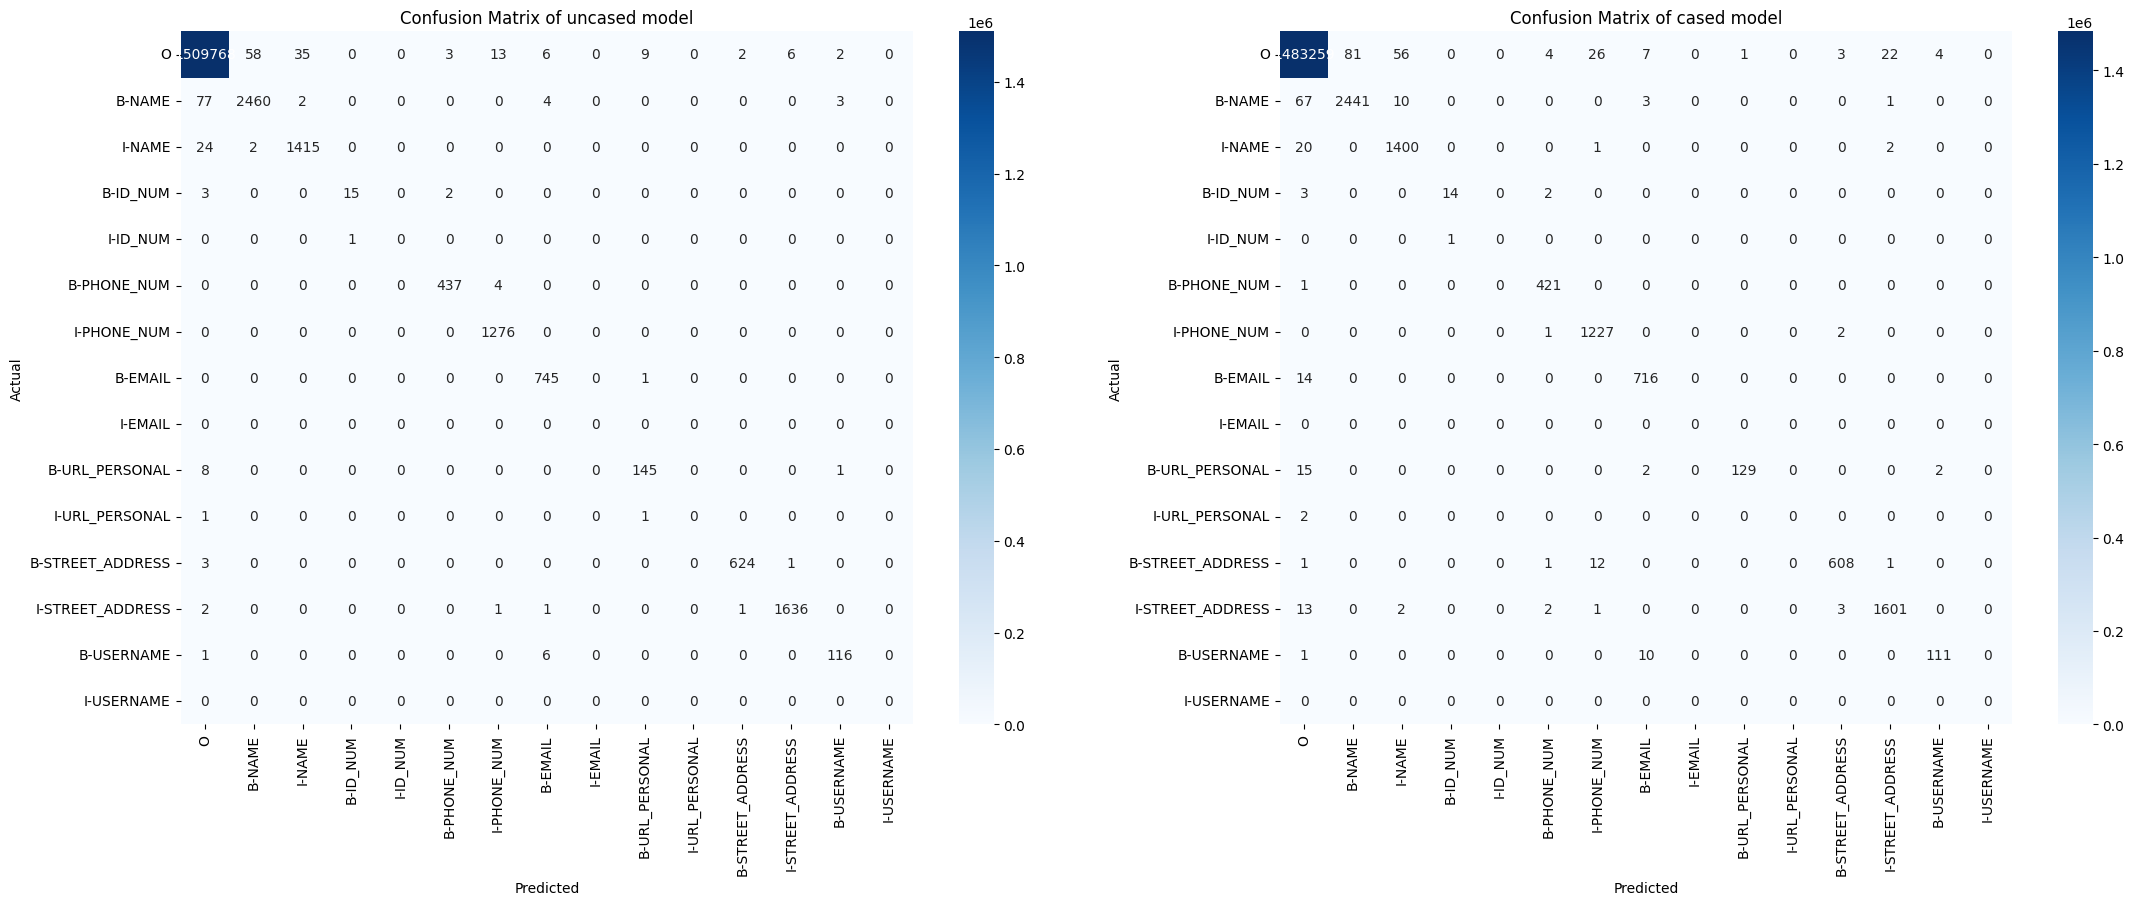

In [18]:
unique_labels_vis = ['O',
 'B-NAME',
 'I-NAME',
 'B-ID_NUM',
 'I-ID_NUM',
 'B-PHONE_NUM',
 'I-PHONE_NUM',
 'B-EMAIL',
 'I-EMAIL',
 'B-URL_PERSONAL',
 'I-URL_PERSONAL',
 'B-STREET_ADDRESS',
 'I-STREET_ADDRESS',
 'B-USERNAME',
 'I-USERNAME']

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(26, 9))

# Plot the first confusion matrix on the first subplot
sns.heatmap(cm1, annot=True, fmt='d', xticklabels=unique_labels_vis, yticklabels=unique_labels_vis, cmap='Blues', cbar=True, ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Confusion Matrix of uncased model')

# Plot the second confusion matrix on the second subplot
sns.heatmap(cm2, annot=True, fmt='d', xticklabels=unique_labels_vis, yticklabels=unique_labels_vis, cmap='Blues', cbar=True, ax=axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_title('Confusion Matrix of cased model')
# Show the figure
plt.show()

- Both models performs very well on the test data as both confusion matrices are close to being diagonal

- Despite a vast overrepresentation of the label "O" in the data set, the models perform well on the other labels as well. 

In [19]:
# Function to calculate metrics for a model
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')
    return [accuracy, precision, recall, f1]

def calculate_metrics_pr_label(true_labels, predicted_labels,unique_labels):
    #accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels,average=None,labels=unique_labels)
    recall = recall_score(true_labels, predicted_labels,average=None,labels=unique_labels)
    f1 = f1_score(true_labels, predicted_labels,average=None,labels=unique_labels)
    return [precision, recall, f1]


In [20]:
# Calculate metrics for both models
metrics_uncased_model = calculate_metrics(uncased_true_labels, uncased_pred_labels)
metrics_cased_model = calculate_metrics(cased_true_labels, cased_pred_labels)

# Create a DataFrame with the metrics for each model
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (macro-average)", "Recall (macro-average)", "F1 Score (macro-average)"],
    "uncased model": metrics_uncased_model,
    "cased model": metrics_cased_model
})

# Display the DataFrame
print(metrics_df.to_string(index=False))

                   Metric  uncased model  cased model
                 Accuracy       0.999813     0.999732
Precision (macro-average)       0.999813     0.999732
   Recall (macro-average)       0.999813     0.999732
 F1 Score (macro-average)       0.999813     0.999732


- Based on the Precision, Recall and F1-score we see that model performance is very high. It is impossible to say which model is better based on these metrics.

In [21]:
precision_uncased_model, recall_uncased_model, f1_uncased_model = calculate_metrics_pr_label(uncased_true_labels, uncased_pred_labels,unique_labels)
precision_cased_model, recall_cased_model, f1_cased_model = calculate_metrics_pr_label(cased_true_labels, cased_pred_labels,unique_labels)

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to co

In [22]:
def color_for_value(value):
    if value < 0.50:
        return "red"
    elif value < 0.70:
        return "yellow"
    else:
        return "green"

# Create an HTML table to display the metrics for both models
html = "<table style='width:100%; border: 1px solid black; border-collapse: collapse;'>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Model Type</th>"
html += "<th colspan='3' style='border: 1px solid black; padding: 8px; font-weight: bold; text-align: center;'>Uncased Model </th>"
html += "<th colspan='3' style='border: 1px solid black; padding: 8px; font-weight: bold; text-align: center;'>Cased Model</th>"
html += "</tr>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Metric</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "</tr>"

# Add data rows for each class and each model
for label, p1, r1, f1, p2, r2, f2 in zip(unique_labels, precision_uncased_model, recall_uncased_model, f1_uncased_model, precision_cased_model, recall_cased_model, f1_cased_model):
    html += f"<tr>"
    html += f"<td style='border: 1px solid black; padding: 8px;'>{label}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p1)};'>{p1:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r1)};'>{r1:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f1)};'>{f1:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p2)};'>{p2:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r2)};'>{r2:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f2)};'>{f2:.2f}</td>"
    html += "</tr>"

# Close the HTML table
html += "</table>"

# Display the HTML table
display(HTML(html))

- When inspecting the precision, recall and f1 for each label, we see that the models perform well on all labels. 
- The labels with a score 0.00 is due to these labels not being present in the test data.
- The only label which are less than 0.90 is the ID_NUM. 

## 6.4 Exploring various use-cases of the model

- In the next section, we will apply our model to a range of use cases that align with our business objectives. We will create our own essays and cover letters to test how effectively the model can identify PIIs. These use cases are directly relevant to our project's focus on detecting PII in text data associated with academic settings and corporate environments as companies for recruitment process and selection.
 
- In the following, we will use the `Cased` model despite no significant difference in performance between the two models on the test data. In order to identify whch model to continue with, we tested both model the following use cases. Here, it occured that the cased model performed slightly better, why we choose to continue with this model. 

### 6.3.1 Extracting PII in educational context to ensure data privacy for students


> - The first use case involves a student essay that contains PII. We will test the model's ability to identify and extract PII from the text. This scenario is particularly relevant for academic institutions seeking to protect student privacy when sharing essays for educational purposes.
>
> All essays contain identical text but vary in the following ways:
>
> - **Essay 1** includes the student's name, email, and phone number to test if the model can successfully identify these PII entities.
> - **Essay 2** aims to assess the model's ability to understand text context by incorporating multiple names. However, these names belong to authors of a paper and should not be recognized as PII by the model.
> - **Essay 3** employs the same name for both the student and the author to determine if this could potentially confuse the model.

**Essay 1:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Johnson  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," these models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

**Essay 2:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Taylor  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

**Essay 3:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Taylor  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Vaswani et al. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

In [6]:
essay1 =  """Title: The Revolution of Transformer Models in AI  
            Student: Jamie Taylor  
            Email: jtaylor@hotmail.dk  
            Phone: 045-456-7890  
            Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," these models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.
            """

essay2 = """Title: The Revolution of Transformer Models in AI  
            Student: Jamie Taylor  
            Email: jtaylor@hotmail.com  
            Phone: 047-456-7890  
            Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.
            """

essay3 = """Title: The Revolution of Transformer Models in AI  
            Student: Jamie Taylor  
            Email: jtaylor@hotmail.gmail  
            Phone: (+961) 456-7890  
            Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Jamie Vaswani et al. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.
        """

In [16]:
def pred_custom_text(text, model):
    essays_spacy_tokenized = tokenize_with_spacy(text, tokenizer=eng_tokenizer)
    pred = model(essays_spacy_tokenized['tokens'])
    labels =  [token[0]['entity'] if token else "O" for token in pred]
    labels = ['B-NAME' if s == "B-NAME_STUDENT" else 'I-NAME' if s == "I-NAME_STUDENT" else s for s in labels]
    text_label = list(zip(essays_spacy_tokenized['tokens'], labels))
    return text_label 

In [17]:
tokenizer_cased = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased", padding=True, truncation=True, is_split_into_words=True, max_length=512, return_tensors="pt")
cased_trained_classifier = pipeline("ner", model=model_cased, tokenizer=tokenizer_cased)

##### Essay 1: Results

In [18]:
visualize_ner_pred_text(essay1, pred_custom_text(essay1,cased_trained_classifier))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<IPython.core.display.HTML object>

##### Essay 2: Results

In [19]:
visualize_ner_pred_text(essay2, pred_custom_text(essay2, cased_trained_classifier))

<IPython.core.display.HTML object>

In [20]:
visualize_ner_pred_text(essay3, pred_custom_text(essay3, cased_trained_classifier))

<IPython.core.display.HTML object>

In our evaluation of the model's performance on essays, we first observe its effectiveness in identifying phone numbers. It accurately distinguishes between beginning (B-PHONE_NUM) and inside (I-PHONE_NUM) markers for phone sequences. Additionally, the model successfully identifies various formats of phone numbers, including those prefixed with country codes (e.g., +961) and those without plus sign (045, 047). It also correctly recognizes email addresses, accommodating a range of domain suffixes such as .dk, .com, and .gmail.

However, the model encounters difficulties with name identification, particularly in distinguishing between actual PII and names that do not constitute PII, such as author names cited in academic papers. For instance, it erroneously labels all author names in the essays as PII. Even when 'et al.' is used to denote multiple authors. Moreover, it fails to differentiate between the beginning of a name (B-NAME) and the continuation (I-NAME), defaulting to classifying all parts of names as B-NAME.

In conclusion, these tests demonstrate the model's capability to detect various forms of PII effectively, yet highlight its shortcomings in accurately classifying names, especially in academic contexts where author citations are not meant to be recognized as PII.

### 6.3.1 Extracting PII in cover letters to ensure data privacy for job applicants and fair hiring practices

The second use case involves a cover letter that contains PII. We will test the model's ability to identify and extract PII from the text. This scenario is particularly relevant for companies seeking to protect job applicants' privacy during the hiring process and unsure unbaised hiring practices.

-  **Cover Letter 1:** The first cover letter includes Name, Email, Phone, and Address to test if the model can successfully identify these PII entities.
- **Cover Letter 2:** The second cover letter includes multiple personal name, but also non-PII name and email of a company. The model should be able to distinguish between these.

**Cover Letter 1**

Dear Hiring Manager,
I am writing to express my interest in the IT position advertised on your website. With a Bachelor’s degree in Computer Science from Stanford University and over three years of experience in IT support and system administration, I am confident in my ability to contribute effectively to your team.

My name is Marie Johnson, and I reside in TX 4294, Avenue Street. You can reach me via email at marie.johnson@gmail.com or by phone at +90 923 9951. My background includes managing network infrastructures and implementing robust IT solutions, which I am eager to bring to your company.

Thank you for considering my application.

Sincerely,
Marie Johnson

**Cover Letter 2**

I previously worked at Green Bean Co, where I enhanced my project management skills by leading several successful initiatives. For further inquiries, please contact Green Bean Co at sa@greenbeanco.com, Att CEO Sam Alter.
You can reach me personally at sami.abdul@hotmail.com.
Best regards,
Sami Abdul

In [22]:
cover_letter_1 = """Dear Hiring Manager,
                I am writing to express my interest in the IT position advertised on your website. With a Bachelor’s degree in Computer Science from Stanford University and over three years of experience in IT support and system administration, I am confident in my ability to contribute effectively to your team.

                My name is Marie Johnson, and I reside in TX 4294, Avenue Street. You can reach me via email at marie.johnson@gmail.com or by phone at +90 923 9951. My background includes managing network infrastructures and implementing robust IT solutions, which I am eager to bring to your company.

                Thank you for considering my application.

                Sincerely,
                Marie Johnson
                """
cover_letter_2 = """I previously worked at Green Bean Co, where I enhanced my project management skills by leading several successful initiatives. For further inquiries, please contact Green Bean Co at sa@greenbeanco.com, Att CEO Sam Alter.
                You can reach me personally at sami.abdul@hotmail.com.
                Best regards,
                Sami Abdul
                """

**Cover Letter 1: Results**

In [23]:
visualize_ner_pred_text(cover_letter_1, pred_custom_text(cover_letter_1, cased_trained_classifier))

<IPython.core.display.HTML object>

**Cover Letter 2: Results**

In [24]:
visualize_ner_pred_text(cover_letter_2, pred_custom_text(cover_letter_2, cased_trained_classifier))

<IPython.core.display.HTML object>

In our second set of tests, which focused on the model's performance on cover letters submitted to companies, we observed promising results. In the first cover letter, the model successfully identified all instances of PII. It correctly recognized the individual's name, although it did not differentiate between the beginning (B-Name) and the continuation (I-Name) of the name. The model also accurately identified the complete address, along with the email and phone number.

In a subsequent test, we aimed to assess the model's ability to discern between names relevant to the person's cover letter and references to corporate entities, such as a CEO or a company email. The model performed well in not misclassifying the CEO's name and email as PII. 

These tests highlight the model's capability to detect PII effectively in most scenarios while also indicating areas where its classification accuracy can be further improved, especially in distinguishing between personal and corporate information.

### 6.3.1 Testing the Model's Contextual Understanding

In this section, we aim to challenge our model to identify its strengths and limitations. This exercise is crucial for ongoing development, helping us pinpoint specific data types that might benefit from additional training.
- **Text 1:** We will craft a narrative about Kenya Thomas to determine if the model correctly identifies this as a person's name rather than the country.
- **Text 2:** We will discuss the country of Kenya to see if the model accurately recognizes it as a geographical location, not a person.
- **Text 3:** We will use the terms "Princess" and "King" in contexts where they serve both as names and nouns, examining whether the model can distinguish these uses based on context.

**Text 1:**
Kenya Thomas has always had a passion for digital art. Since her childhood in Miami, she has been fascinated by the power of visuals and how they can convey complex emotions and stories. Now a graduate from the Rhode Island School of Design, Kenya focuses on blending traditional painting techniques with modern digital tools to create vibrant, emotive pieces. Her latest series, "Digital Waves," explores themes of connectivity and isolation in the digital age. Kenya’s work has been featured in several art galleries across the Northeast, garnering attention for her unique style and innovative approach to digital media.

**Text 2:**
Kenya, a country rich in culture and natural beauty, is renowned for its breathtaking landscapes and diverse wildlife. The nation's commitment to conservation is evident in its numerous national parks and reserves, including the world-famous Maasai Mara. This reserve is part of the Serengeti ecosystem and hosts the annual wildebeest migration, a spectacular natural event that attracts thousands of visitors from around the globe. Beyond wildlife, Kenya is also celebrated for its vibrant cultural heritage, including numerous tribes such as the Maasai, known for their distinctive customs and colorful attire. Tourism, deeply intertwined with conservation and community initiatives, plays a crucial role in Kenya's economy.

**Text 3:**
It is funny that my name is Princess however I am not a princess, and my brothers name is King but of course is he not a king at all. 


In [40]:
Text1 = """
Kenya Gohler has always had a passion for digital art. Since her childhood in Miami, she has been fascinated by the power of visuals and how they can convey complex emotions and stories. Now a graduate from the Rhode Island School of Design, Kenya focuses on blending traditional painting techniques with modern digital tools to create vibrant, emotive pieces. Her latest series, "Digital Waves," explores themes of connectivity and isolation in the digital age. Kenya’s work has been featured in several art galleries across the Northeast, garnering attention for her unique style and innovative approach to digital media.
"""

Text2 = """
Kenya, a country rich in culture and natural beauty, is renowned for its breathtaking landscapes and diverse wildlife. The nation's commitment to conservation is evident in its numerous national parks and reserves, including the world-famous Maasai Mara. This reserve is part of the Serengeti ecosystem and hosts the annual wildebeest migration, a spectacular natural event that attracts thousands of visitors from around the globe. Beyond wildlife, Kenya is also celebrated for its vibrant cultural heritage, including numerous tribes such as the Maasai, known for their distinctive customs and colorful attire. Tourism, deeply intertwined with conservation and community initiatives, plays a crucial role in Kenya's economy.
"""

Text3 = """
It is funny that my name is Princess however I am not a princess, and my brothers name is King but of course is he not a king at all. 
"""

In [49]:
visualize_ner_pred_text(Text1, pred_custom_text(Text1, cased_trained_classifier))

<IPython.core.display.HTML object>

In [50]:
visualize_ner_pred_text(Text2, pred_custom_text(Text2, cased_trained_classifier))

<IPython.core.display.HTML object>

We see that the model does not recognize the name "Kenya" in the first text. In the second text, we see that the model identifies other locations in Kenya as names.

In [51]:
visualize_ner_pred_text(Text3, pred_custom_text(Text3, cased_trained_classifier))

<IPython.core.display.HTML object>

This is a great example of how the model succes in understanding the context, where the model recognize the names "Princess" and "King" as names and does not recognize them as names in used as nouns. However, this could also be due to the capital letters. 

Thus, we test the same text, but with lowercased name.

In [41]:
Text4 = """
It is funny that my name is princess however I am not a princess, 
"""

In [52]:
visualize_ner_pred_text(Text4, pred_custom_text(Text4, cased_trained_classifier))

<IPython.core.display.HTML object>

Thus, we see that the model suffer from contextual understanding.

__________

<a id="7"></a>
# Section 7: Discussion

- Despite our transformer model performing well on test data and specific use cases, it struggles with context understanding within texts. This issue became apparent in essay evaluations and a contextual test, where the model failed to differentiate between country names and personal names. Additionally, the model might be to dependent on uppercase letters to identify names, as demonstrated in the case of the word "princess".

- These observations suggest that while the model perform well on test data, its ability to generalize to broader contexts is limited. We believe that incorporating a more diverse dataset could enhance the model's understanding of context, leading to improved performance across varied applications.

- Futhermore, the model struggles to differentiate between B-NAME and I-NAME. Training the model to recognize a single NAME category and subsequently applying a mapping to distinguish between B and I could be more effective. This approach would not only streamline the training process by reducing the number of classes but also potentially enhance the model's accuracy.

- We initially planned to integrate a rule-based approach with our deep learning model, using the rule-based system where it showed superior labeling performance. However, we observed that the transformer model consistently outperformed the regex-based model across all targets, why we did not include the rule-based approach in the final model.

- Despite our model's flaws, it is important to note that the model performed well on the test data and specific use cases. This indicates that the model is capable of identifying PII in a variety of contexts, which is crucial for our project's objectives.